SETUP TENSORFLOW IN UR SYSTEM 

In [4]:
# this part of code import all modules we will use in our model 
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import time
import uuid 

SETUP TENSORFLOW DEPENDENCIES

In [5]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

#LIMITING GPU GROWTH 


In [6]:
# # Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus: 
#     tf.config.experimental.set_memory_growth(gpu, True)
# IF U HAVE GPU IN UR SYSTEM 

#Creating Paths

In [7]:
# this creates a directory named data and makes subdirectories positive, negative and anchor in it 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

##2. Collect Positives and Anchors

2.1 Untar Labelled Faces in the Wild Dataset

In [ ]:
# https://www.kaggle.com/datasets/atulanandjha/lfwpeople
# download datset from here 

In [ ]:
##no need do to this step just unzip the files manually and put in the directory same as ur notebook
# !tar -xf lfw.tgz(just for unzipping)

In [ ]:
for directory in os.listdir('lfw_funneled'):#Selects each item in given directory 
    for file in os.listdir(os.path.join('lfw_funneled', directory)):#selects path for each file in that directory 
        EX_PATH = os.path.join('lfw_funneled', directory, file)#assigns path with file type
        NEW_PATH = os.path.join(NEG_PATH, file)#changes path
        os.replace(EX_PATH, NEW_PATH)#assigns new path 
        #ensure that u extracted dataset properly before running this block , this block will return all images in negative folder created earlier 

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw_funneled'

2.2 Collect Positive and Anchor Classes

In [8]:
import uuid #universally unique identifiers  can be used to create unique filenames or directory names. However, it does not handle saving images or managing paths

In [9]:
ANC_PATH
POS_PATH
#try running if paths are created properly 

'data\\positive'

In [ ]:
# ignore these lines pls
#testing web cam 
#displayes image also 
#this code connects opencv and webcam of ur system
# cap = cv2.VideoCapture(0) #webcam device might be diffrent try with 0,1,2,3,4 etc.. 

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # Convert BGR to RGB for correct color representation
#     frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#     # Display frame using Matplotlib
#     plt.imshow(frame_rgb)
#     plt.axis('off')
#     plt.show()

#     # Wait for 'q' key to exit
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break
#interrept not working correctly 
# cap.release()
# cv2.destroyAllWindows()



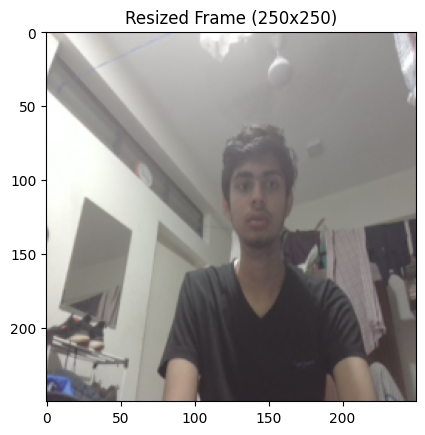

In [ ]:
import cv2
import time #if u want to exit manually after some delay we need to import time module

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)#try this with different video inputs (0,1,2,3..) might be diffrent for ur system

# start_time = time.time()  # Get the current time

while cap.isOpened():
    ret, frame = cap.read()
    
    # Show image back to screen
    # cv2.imshow('Image Collection', frame)
    resized_frame = cv2.resize(frame, (250, 250), interpolation=cv2.INTER_AREA)#resizing to 250X250
    cv2.imshow('Resized Image', resized_frame)
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, resized_frame)
     # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, resized_frame)
    
    # Breaking gracefully after 5 seconds
    # if (time.time() - start_time) > 5:  # Check if 5 seconds have passed
    #     break

    if cv2.waitKey(1) & 0xFF == ord('q'):  # Allow manual exit
        break
    

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()
frame.shape
plt.imshow(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
plt.title("Resized Frame (250x250)")
plt.show()



SECTION 3 

3.1 Get Image Directories

In [14]:
anchor = tf.data.Dataset.list_files(f"{ANC_PATH}/*.jpg").take(300)
positive = tf.data.Dataset.list_files(f"{POS_PATH}/*.jpg").take(300)
negative = tf.data.Dataset.list_files(f"{NEG_PATH}/*.jpg").take(300)


In [15]:
dir_test = anchor.as_numpy_iterator()

In [16]:
print(dir_test.next())

b'data\\anchor\\671d4a70-01c5-11f0-97ff-c85ea927c210.jpg'


3.2 Preprocessing - Scale and Resize

In [10]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [11]:
img = preprocess('data\\anchor\\b42043bc-01c4-11f0-9b3a-c85ea927c210.jpg')
img.numpy().max() 

AttributeError: module 'ml_dtypes' has no attribute 'float4_e2m1fn'


0.9379902

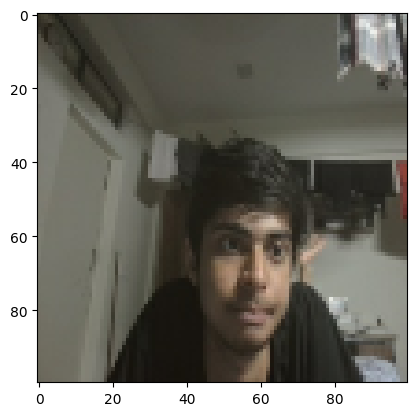

In [12]:
plt.imshow(img)

In [ ]:
# dataset.map(preprocess)

SECTION 3.3

#
This code creates a dataset for training a similarity model by pairing anchor samples with both positive (similar) and negative (dissimilar) samples, labeling them as 1.0 and 0.0, respectively. It then merges these labeled pairs into a single dataset for training.

In [17]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samples = data.as_numpy_iterator()
exampple = samples.next()

In [19]:
exampple

(b'data\\anchor\\6abc1a62-01c5-11f0-8c5f-c85ea927c210.jpg',
 b'data\\positive\\022c3762-01c4-11f0-86ec-c85ea927c210.jpg',
 1.0)

SECTION 3.4


This code:

Preprocesses and caches the dataset.
Shuffles the data to avoid bias.
Splits the dataset into 70% training and 30% testing.
Batches data into chunks of 16 samples.
Prefetches batches for efficient training and testing.

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

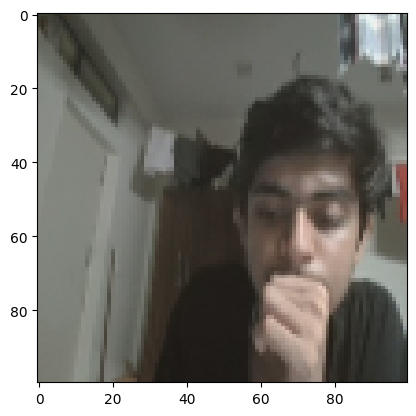

In [21]:
res = preprocess_twin(*exampple)
plt.imshow(res[1])

In [50]:
res[2]

1.0

In [22]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [23]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

section 4 

4.1 making embedded layer

In [27]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=inp, outputs=d1, name='embedding')

In [32]:
embedding = make_embedding()

In [19]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

4.2 Build Distance Layer

In [28]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [29]:
l1 = L1Dist()

In [23]:
# l1((anchor_embedding, validation_embedding))

4.3 Making final siamese model 


In [30]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

testing step by step 

In [6]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [23]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [24]:
siamese_layer = L1Dist()

In [54]:
distances = siamese_layer(inp_embedding, val_embedding)

In [55]:
classifier = Dense(1, activation='sigmoid')(distances)

In [56]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_16>

In [33]:
siamese_model = make_siamese_model()

In [32]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

5. Training ML Model 

section 5.1

Setup Loss and Optimizer

In [34]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [35]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

5.2 Establish Checkpoints

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 Build Train Step Function

In [38]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

testing

In [57]:
test_batch = train_data.as_numpy_iterator()

In [58]:

batch_1 = test_batch.next()

In [59]:

X = batch_1[:2]

In [60]:

y = batch_1[2]

In [61]:

y

array([1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

In [63]:

# tf.losses.BinaryCrossentropy??


5.4 Build Training Loop

In [39]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 Train the model

In [ ]:
EPOCHS = 30

In [66]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 68s 3s/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step

 Epoch 15/50
27/27 ━━━━━━

section 6 evalation of model 

6.1

In [1]:
from tensorflow.keras.metrics import Precision, Recall

6.2 making predictions 

In [131]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [132]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 678ms/step


array([[0.50039625],
       [0.50045216],
       [0.50147676],
       [0.49987194],
       [0.5023029 ],
       [0.5004537 ],
       [0.5004766 ],
       [0.5015774 ],
       [0.50252044],
       [0.5012225 ],
       [0.50282073],
       [0.50344825],
       [0.5016717 ],
       [0.5011873 ],
       [0.50014675],
       [0.5017984 ]], dtype=float32)

In [133]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [134]:
y_true

array([1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

6.3 Calculate Metrics

In [144]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.85714287

In [145]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

0.4

6.4 plotting results 

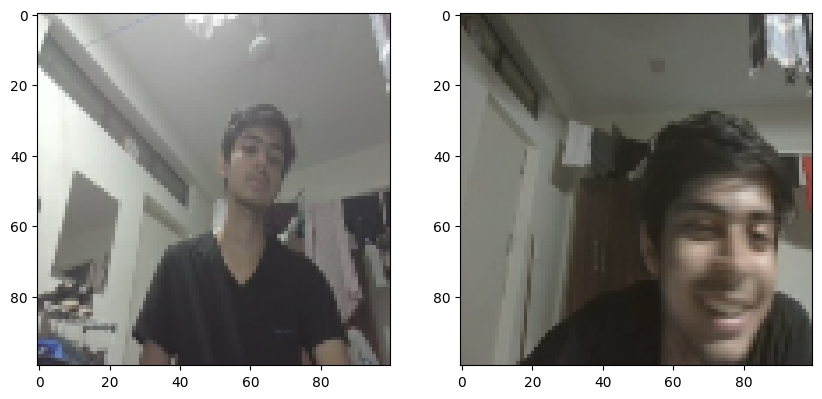

In [146]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[14])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[14])

# Renders cleanly
plt.show()

section 7 saving

7.1

In [147]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [149]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
 custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [150]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 821ms/step


array([[0.50039625],
       [0.50045216],
       [0.50147676],
       [0.49987194],
       [0.5023029 ],
       [0.5004537 ],
       [0.5004766 ],
       [0.5015774 ],
       [0.50252044],
       [0.5012225 ],
       [0.50282073],
       [0.50344825],
       [0.5016717 ],
       [0.5011873 ],
       [0.50014675],
       [0.5017984 ]], dtype=float32)

In [151]:
# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_4 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)